Здесь исследуются различные нелинейные слагаемые, через которые получает энергию стационарная продольная завихренность. Для периодического порыва, Re=2200. Обозначения вводились раньше, это cux, cvx, cwx, d1x, d2x, d3x, вычисленные по среднему течения и по пульсационной составляющей. Во всех без исключения случаях рассматриваются величины, умноженные на Ox (продольную завихренность среднего течения), то есть вклад в энергию средней продольной завихренности. В общем действует правело, что слагаемые, вычисленные по среднему течению, обозначаются большими буквами, например CUX. Вычисленные по пульсационной составляющей - обозначаются маленькими буквами с 1 или штрихом на конце, например cux1.

In [1]:
import math

import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pipeSym_func as sym

In [2]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,VEL = tl.get_scp("../../orig-edge/Re2200-mean.scp")

In [11]:
U,V,W = VEL

In [3]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [4]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [5]:
x.f -= x.f[836]

In [6]:
cx = tl.get_scp("Re2200_cx.scp")[-1]

dx = tl.get_scp("Re2200_dx.scp")[-1]

In [7]:
puls = tl.get_scp("../../orig-edge/Re2200-mean2.scp")[-1] - VEL**2

In [8]:
def cs_mean(u):
    res = 0.0
    ss = 0.0
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            res += u[k,j] * yt1[j] * yt[j] * ht
            ss += yt1[j] * yt[j] * ht
    return res / ss

In [9]:
def xmean(u):
    u1_mean = []
    for i in range(0,Im+2):
        u1_mean.append(cs_mean(u[:,:,i]))

    u1_mean[0] = u1_mean[-2]
    u1_mean[-1] = u1_mean[1]

    return np.array(u1_mean)

In [12]:
U2D = VEL[0].copy()
for j in range(1,Jm+1):
    for i in range(1,Im+1):
        U2D[:,j,i] -= U[1:-1,j,i].mean(0)

(-40, 20)

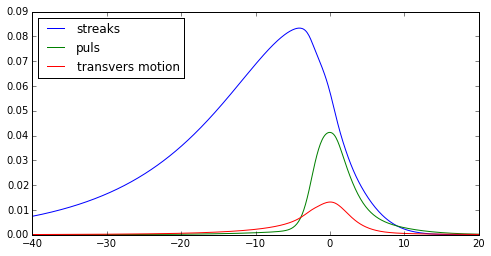

In [13]:
plt.figure(figsize=(8,4))
plt.plot(x.f, xmean(U2D**2)**0.5, label="streaks")
plt.plot(x.f, xmean(puls[0] + puls[1] + puls[2])**0.5, label="puls")
plt.plot(x.f, xmean(VEL[1]**2 + VEL[2]**2)**0.5, label="transvers motion")
plt.legend(loc=2)
plt.xlim(-40,20)

Рис.1. Стандартная картинка, чтобы ориентироваться. Ноль установлен в сечение, в котором максимум пульсаций. 

In [14]:
ii = 836

In [15]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [16]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [17]:
OM = rot(VEL)

In [18]:
OX,OR,OT = OM

In [19]:
def get_nl(vel, om):
        u,v,w = vel
        ox,on,ot = om
        
        ut = np.zeros_like(u)
        ur = np.zeros_like(u)
        ux = np.zeros_like(u)
        vx = np.zeros_like(v)
        wx = np.zeros_like(w)
        oxx = np.zeros_like(ox)
        oxr = np.zeros_like(ox)
        oxt = np.zeros_like(ox)


        for k in range(1,Km+1):
            for j in range(1,Jm+1):
                for i in range(1,Im+1):
                    ut[k,j,i] = (u[k+1,j,i] - u[k,j,i]) / (rt[j] * ht)
                    ur[k,j,i] = (u[k,j+1,i] - u[k,j,i]) / rt1[j]
                    ux[k,j,i] = (u[k,j,i+1] - u[k,j,i]) / hx
                    vx[k,j,i] = (v[k,j,i+1] - v[k,j,i]) / hx
                    wx[k,j,i] = (w[k,j,i+1] - w[k,j,i]) / hx
                    oxx[k,j,i] = (ox[k,j,i+1] - ox[k,j,i]) / hx
                    oxr[k,j,i] = (ox[k,j+1,i] - ox[k,j,i]) / rt1[j]
                    oxt[k,j,i] = (ox[k+1,j,i] - ox[k,j,i]) / (rt[j] * ht)


        cx = sym.new_z_vfield()
        dx = sym.new_z_vfield()
        cux,cvx,cwx = cx
        d1x,d23x,_ = dx
        
        cux = -u*oxx
        cvx = -v*oxr
        cwx = -w*oxt
        d1x = ox*ux
        d23x = vx*ut - ur*wx
        
        return cux,cvx,cwx,d1x,d23x
    

In [20]:
CUX,CVX,CWX,D1X,D23X = get_nl(VEL,OM)

In [22]:
cux,cvx,cwx = cx
d2x,d23x,_ = dx

In [23]:
for i in range(1,Im+1):
    CUX.T[i] += cf * (OX.T[i+1] - OX.T[i-1]) / (2*hx)
    cux.T[i] += cf * (OX.T[i+1] - OX.T[i-1]) / (2*hx)

In [24]:
d1x = dx[0]
d23x = dx[1]
cux = cx[0]
cvx = cx[1]
cwx = cx[2]

In [25]:
cux1 = cux - CUX
cvx1 = cvx - CVX
cwx1 = cwx - CWX
d1x1 = d1x - D1X
d23x1 = d23x - D23X

In [27]:
nl = cux+cvx+cwx+d1x+d23x

In [29]:
nl1 = cux1+cvx1+cwx1+d1x1+d23x1

NL = CUX+CVX+CWX+D1X+D23X

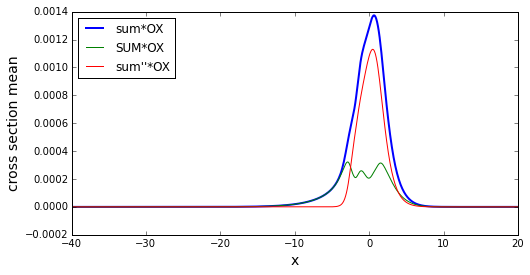

In [30]:
plt.figure(figsize=(8,4))
plt.plot(x.f, xmean(OX*nl), label="sum*OX", lw=2)
plt.plot(x.f, xmean(OX*NL), label="SUM*OX")
plt.plot(x.f, xmean(OX*nl1), label="sum''*OX")
plt.legend(loc=2)
plt.xlim(-40,20)
plt.xlabel("x", fontsize=14)
plt.ylabel("cross section mean", fontsize=14)

Рис.2. Всё - средние по сечению. Жирная синяя линия - суммарный вклад в энергию продольной завихренности от всех нелинейных слагаемых. Красная линия, практически совпадающая с синей - вклад от пульсационной составляющей движения. Зеленая линия - вклад от стационарной составляющей движения. Вклад стационарного течения значительно меньше, чем вклад пульсаций, но тем не менее всегда остается положительным. 

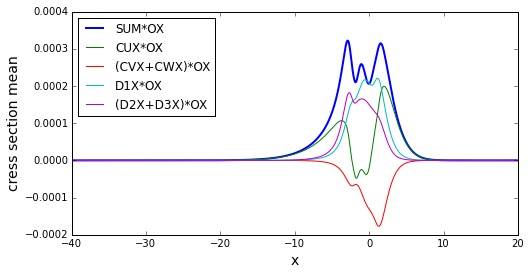

In [31]:
plt.figure(figsize=(8,4))
plt.plot(x.f, xmean(OX*NL), label="SUM*OX", lw=2)
plt.plot(x.f, xmean(OX*CUX), label="CUX*OX")
plt.plot(x.f, xmean(OX*(CVX+CWX)), label="(CVX+CWX)*OX")
plt.plot(x.f, xmean(OX*D1X), label="D1X*OX")
plt.plot(x.f, xmean(OX*D23X), label="(D2X+D3X)*OX")
plt.legend(loc=2)
plt.xlim(-40,20)
plt.xlabel("x", fontsize=14)
plt.ylabel("cress section mean", fontsize=14)

Рис.3. Слагаемые, из которых складывается вклад от среднего течения. Жирная синяя линия - суммарный вклад, уже был приведен на предыдущем графике. Зеленая линия, имеющая два ярко выраженных пика - конвекция за счет U. Красная линия, всегда отрицательна - конвекция в поперечной плоскости. Я решил объединять слагаемые cvx+cwx в одно, так как они во многом компенсируют друг друга во всех случаях и никогда не дают большой вклад. Голубая и фиолетовая кривые - вклад от деформационных слагаемых. 

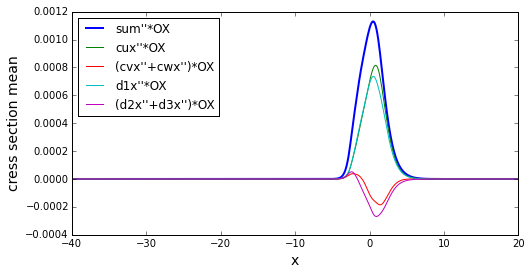

In [32]:
plt.figure(figsize=(8,4))
plt.plot(x.f, xmean(OX*nl1), label="sum''*OX", lw=2)
plt.plot(x.f, xmean(OX*cux1), label="cux''*OX")
plt.plot(x.f, xmean(OX*(cvx1+cwx1)), label="(cvx''+cwx'')*OX")
plt.plot(x.f, xmean(OX*d1x1), label="d1x''*OX")
plt.plot(x.f, xmean(OX*d23x1), label="(d2x''+d3x'')*OX")
plt.legend(loc=2)
plt.xlim(-40,20)
plt.xlabel("x", fontsize=14)
plt.ylabel("cress section mean", fontsize=14)

Рис.4. Жирная синяя линия - суммарный вклад от пульсаций, уже был приведен на рис.2. Зеленая и голубая линии, практически совпадающие, положительные - вклад от слагаемых cux и d1x. Именно они дают основной вклад, как в этом случае, так и в бегущей волне. Красная линия, имеющая отрицательное значения - вклад от конвекции в поперечной плоскости, то есть сумма слагаемых cvx + cwx. Фиолетовая линия, практически совпадает с красной - вклад деформационных слагаемых d2x+d3x.

In [33]:
def mean_polar_plot(oxs, oname, spm=None):
    oxm = oxs[:,:,ii]
    oxm += oxm[::-1,:]
    oxm /= 2
    
    opm = 0.0
    ss = 0.0
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            opm += oxm[k,j]*yt[j]*yt1[j]*ht
            ss += yt[j]*yt1[j]*ht
    opm /= ss
    
    pp.polar_contourf(yt, th.f, oxm, (-0.02,0.02))
    
    if spm == None: spm = opm
    if spm < 0: spm *= -1
    plt.xlabel("%s, int=%4.2f" % (oname, opm/spm), fontsize=14)
    
    return opm

In [34]:
smax = xmean(OX*nl).max()

In [37]:
omax = max(OX.max(), -OX.min())

In [49]:
def nl_plot():

    plt.figure(figsize=(15,15))

    plt.subplot(5,5,1)
    plt.title("x = %4.1f R" % (x.f[ii]),fontsize=14)
    mean_polar_plot(nl*OX, 'sum', smax)

    
    plt.subplot(5,5,5)
    pp.polar_contourf(yt, th.f, OX[:,:,ii], (-omax,omax))
    plt.xlabel("OX, max=%4.2f" % (OX[:,:,ii].max() / omax),fontsize=14)


    plt.subplot(5,5,6)
    mean_polar_plot(NL*OX, 'SUM', smax)
    plt.ylabel("mean * mean", fontsize=14)

    plt.subplot(5,5,7)
    mean_polar_plot(CUX*OX, 'CUX', smax)
    plt.ylabel("||")

    plt.subplot(5,5,8)
    mean_polar_plot((CVX+CWX)*OX, 'CVX+CWX', smax)
    plt.ylabel("+",fontsize=14)

    plt.subplot(5,5,9)
    mean_polar_plot(D1X*OX, 'D1X', smax)
    plt.ylabel("+",fontsize=14)

    plt.subplot(5,5,10)
    mean_polar_plot(D23X*OX, 'D2X+D3X', smax)
    plt.ylabel("+",fontsize=14)
    
    
    plt.subplot(5,5,11)
    mean_polar_plot(nl1*OX, "sum'", smax)
    plt.ylabel("puls * puls", fontsize=14)

    plt.subplot(5,5,12)
    mean_polar_plot(cux1*OX, "cux'", smax)
    plt.ylabel("||")

    plt.subplot(5,5,13)
    mean_polar_plot((cvx1+cwx1)*OX, "cvx'+cwx'", smax)
    plt.ylabel("+",fontsize=14)

    plt.subplot(5,5,14)
    mean_polar_plot(d1x1*OX, "d1x'", smax)
    plt.ylabel("+",fontsize=14)

    plt.subplot(5,5,15)
    mean_polar_plot(d23x1*OX, "d2x'+d3x'", smax)
    plt.ylabel("+",fontsize=14)

Далее приведено распределение каждого из слагаемых в различных сечения, чтобы иметь возможно выбрать, что включить в презентацию. 

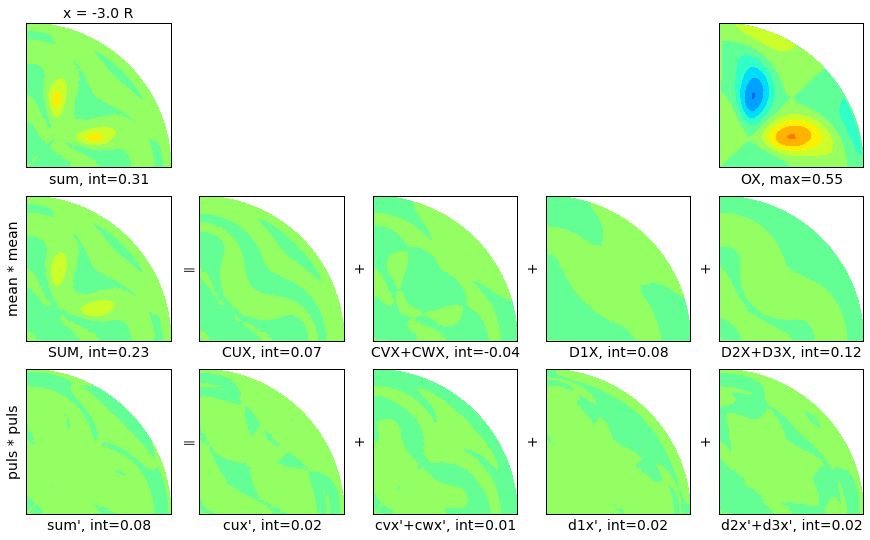

In [50]:
ii = 810
nl_plot()

Рис.5. Одно сечение трубы x=-3R. Оно подписано сверху. Первая картинка - суммарный вклад всех нелинейных слагаемых в этом сечении. Под ней две картинки - суммарный вклад от стационарного течения (первая картинка по втором ряду) и суммарный вклад от пульсаций (первая картинка в третьем ряду). Все остальные картинки во втором ряду - различные слагаемые вклада от стационарного течения. В третьем ряду - слагаемые вклада от пульсаций. Вторая колонка - конвекция вдоль трубы cux. Третья - конвекция в поперечной плоскости cvx+cwx. Четвертая - деформация завихренности вдоль трубы d1x. Пятая - два других деформационных слагаемых d2x+d3x. 

Числа под рисунками - средние по сечению от изображенной величины, обезразмеренные на максимальное значение, которое принимает суммарный вклад от всех нелинейных слагаемых (примерно в сечении х=1R). 

Добавлена продольная завихренность в верхнем правом углу. В подписи указано максимальное значние в сечении, отнесенное к максимальному значниею в трубе. 

В общем, картина такова, что все слагаемые, кроме cux+d1x дают порядка 0.1 максимум, и часто компенсируют друг друга, так что основную роль играют cux+d1x. Суммарный вклад стационарного течение примерно 0.2 во всех приведенных сечениях. 

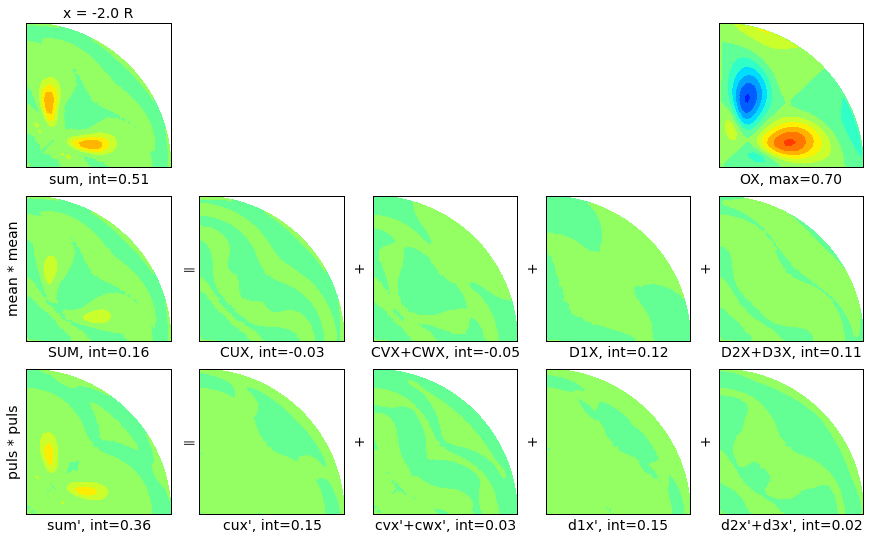

In [51]:
ii = 819
nl_plot()

Рис.6. Все тоже, что и на предыдущем рисунке, но для сечения x=-2R. 

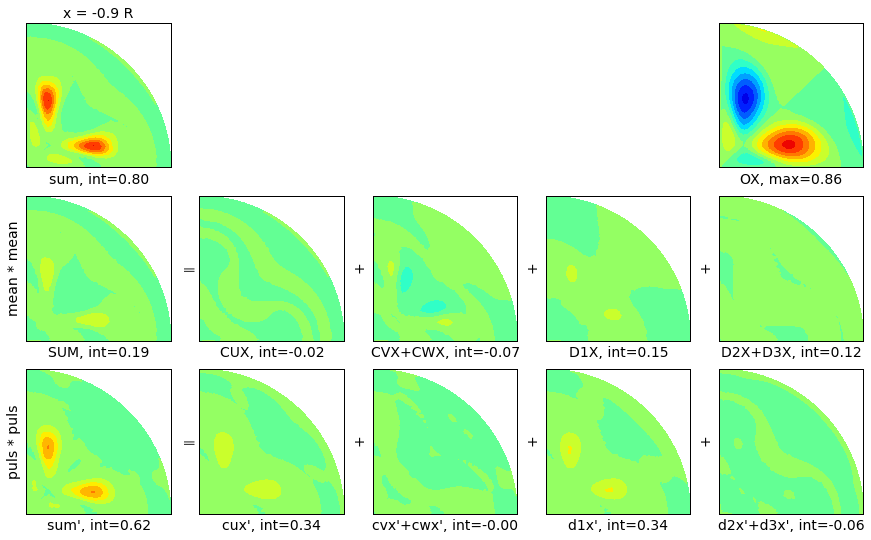

In [52]:
ii = 828
nl_plot()

Рис. 7. Все тоже, что и на предыдущем графике, но для сечения x=-1R.

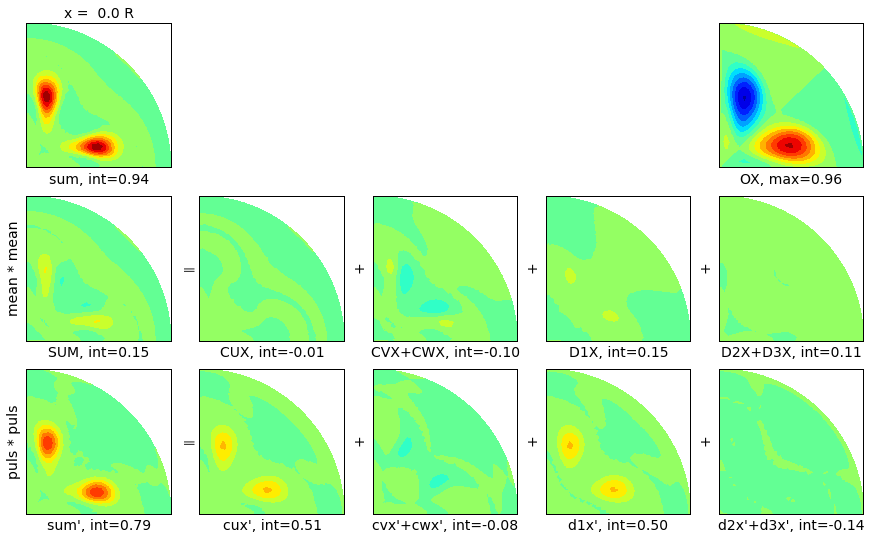

In [53]:
ii = 836
nl_plot()

Рис. 8. Все тоже, что и на предыдущем графике, но для сечения x=0. Решающее значение имеет сумма cux+d1x. В этом и следующем сечении суммарный вклад максимальные. 

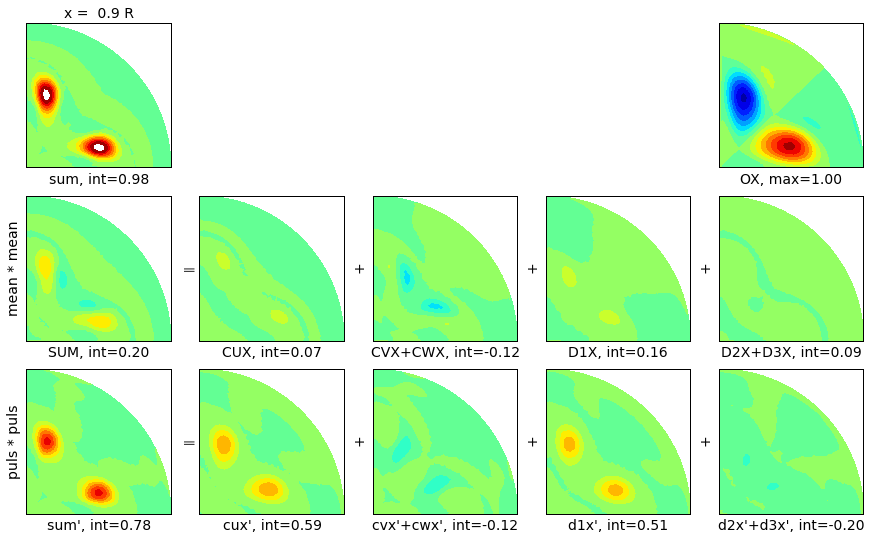

In [54]:
ii = 844
nl_plot()

Рис. 9. Все тоже, что и на предыдущем графике, но для сечения x=1R. Ситуация такая же, как и на предыдущем рисунке. Одно из этих сечений можно взять для презентации.

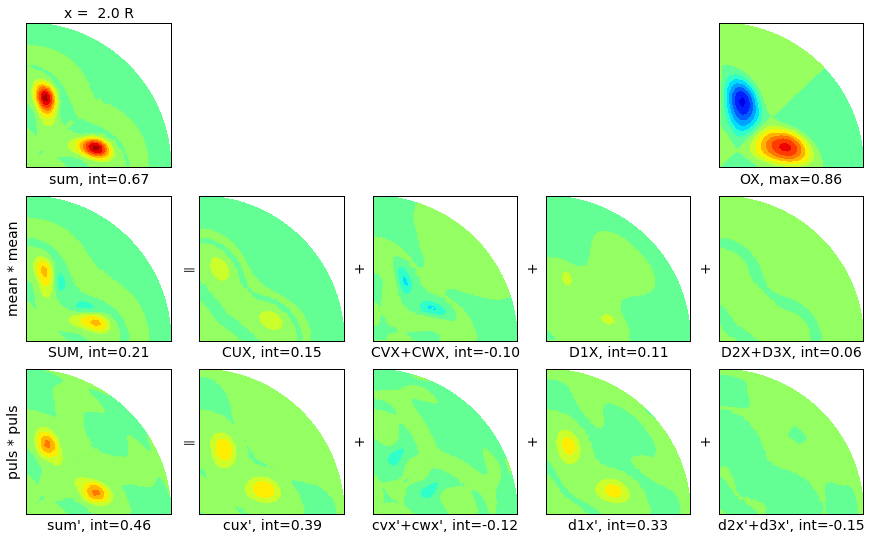

In [55]:
ii = 853
nl_plot()

Рис. 10. Все тоже, что и на предыдущем графике, но для сечения x=2R.

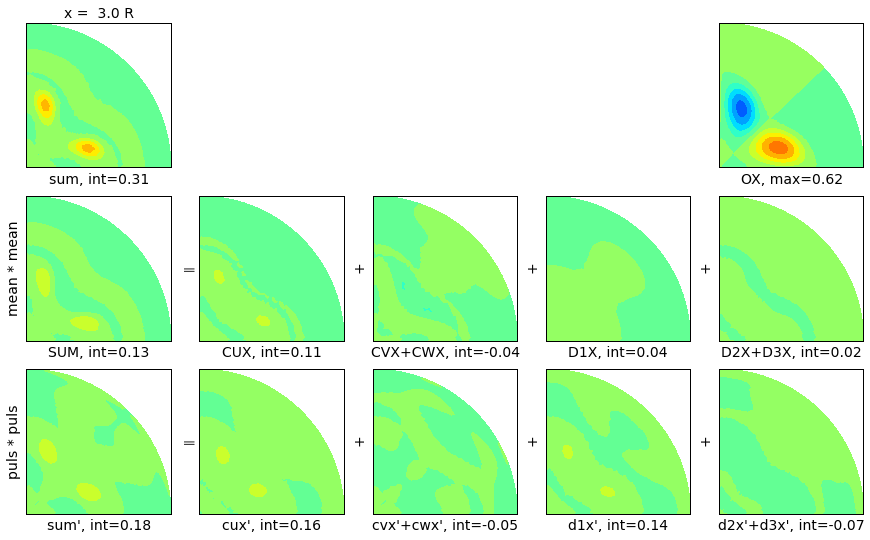

In [56]:
ii = 862
nl_plot()

Рис. 11. Все тоже, что и на предыдущем графике, но для сечения x=3R.

В общем, для презентации, я думаю, стоит выбрать сечение x=1R. Далее будут приведены картинки из этого сечения для презентации. Хотя подписи под ними вряд ли будут кому-то понятны, я решил их оставить, чтобы по крайней мере вы могли расшифровать, что изображено. Рисунки можно копировать прямо из этого файла, нажав правой кнопкой мыши на рисунок, и выбрав "сохранить рисунок как". Плюс к тем, что были, приведена еще сумма cux+d1x.

In [57]:
ii = 844

In [73]:
def mean_polar_plot(oxs, oname, spm=None):
    oxm = oxs[:,:,ii]
    oxm += oxm[::-1,:]
    oxm /= 2
    
    opm = 0.0
    ss = 0.0
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            opm += oxm[k,j]*yt[j]*yt1[j]*ht
            ss += yt[j]*yt1[j]*ht
    opm /= ss
    
    pp.polar_contourf(yt, th.f, oxm, (-0.021,0.021))
    
    if spm == None: spm = opm
    if spm < 0: spm *= -1
    plt.xlabel("OX*%s, int=%4.2f" % (oname, opm/spm), fontsize=16)
    
    return opm

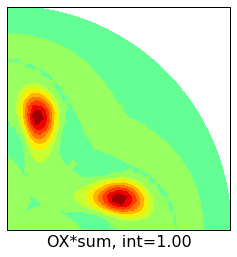

In [74]:
smax = mean_polar_plot(nl*OX, 'sum')

Суммарный вклад от всех нелинейных слагаемых.

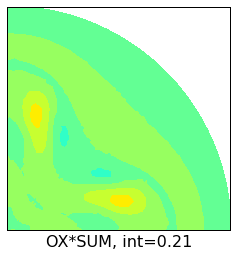

In [75]:
_ = mean_polar_plot(NL*OX, 'SUM', smax)

Суммарный вклад от стационарной составляющей течения. Ниже различные слагаемые, вычисленные по стационарному течению. 

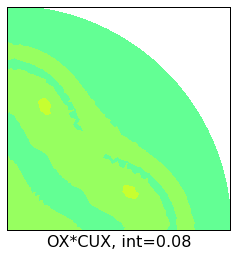

In [76]:
_ = mean_polar_plot(CUX*OX, 'CUX', smax)

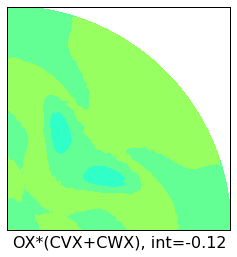

In [77]:
_ = mean_polar_plot((CVX+CWX)*OX, '(CVX+CWX)', smax)

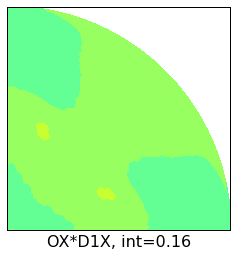

In [78]:
_ = mean_polar_plot(D1X*OX, 'D1X', smax)

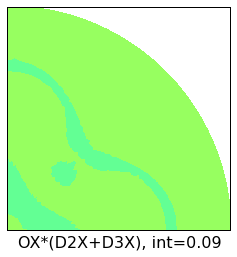

In [79]:
_ = mean_polar_plot(D23X*OX, '(D2X+D3X)', smax)

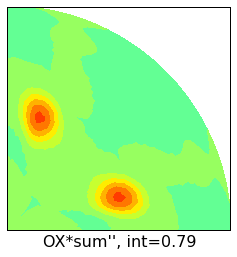

In [80]:
_ = mean_polar_plot(nl1*OX, "sum''", smax)

Суммарный вклад от пульсационной составляющих движения. Ниже его компоненты. 

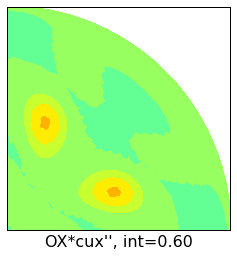

In [81]:
_ = mean_polar_plot(cux1*OX, "cux''", smax)

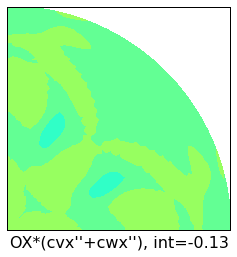

In [83]:
_ = mean_polar_plot((cvx1+cwx1)*OX, "(cvx''+cwx'')", smax)

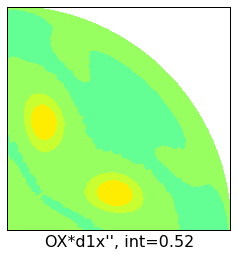

In [84]:
_ = mean_polar_plot(d1x1*OX, "d1x''", smax)

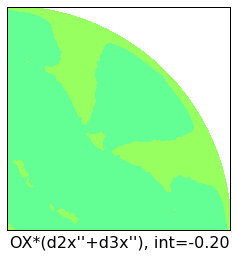

In [85]:
_ = mean_polar_plot(d23x1*OX, "(d2x''+d3x'')", smax)

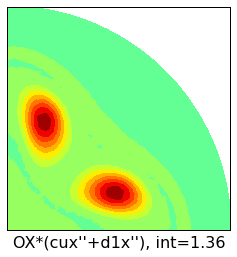

In [86]:
_ = mean_polar_plot((cux+d1x)*OX, "(cux''+d1x'')", smax)

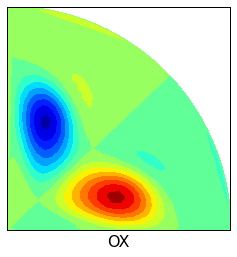

In [87]:
omax = OX[:,:,ii].max()
pp.polar_contourf(yt, th.f, OX[:,:,ii], (-omax,omax))
plt.xlabel("OX",fontsize=16)

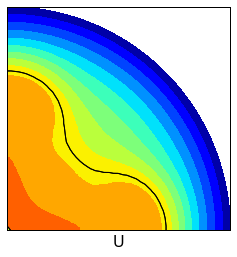

In [72]:
pp.polar_contourf(yt, th.f, U[:,:,ii], (0,1))
pp.polar_contour(yt, th.f, U[:,:,ii], cf)
plt.xlabel("U",fontsize=16)

In [521]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')